In [1]:
import numpy as np
import pandas as pd
import artist_info_helper as aih
import track_info_helper as tih

import glob, os, re, sys
from datetime import datetime
import pickle
import time
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [2]:
# features that we want to analyze
testdict = tih.TrackInfoDict()
features = testdict.keys
features = [feature for feature in features if feature not in ['ids', 'names', 'artists', 'release_date', 'popularity']]
features += ['monthly_listeners', 'days_since_release'] # derived quantities for this notebook
vmins, vmaxs = testdict.vmins, testdict.vmaxs

CRITICAL:track_info_helper:Need to provide both tracks_info and tracks_audio_info to initialize TrackInfoDict.


# load the random track data for the random artist sample

In [6]:
DEFAULT_RND_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/"
df = pd.read_csv(DEFAULT_RND_DIR + "Spotify_artist_info_tracks.csv")
print(df.columns)
df.describe()

Index(['ids', 'names', 'popularity', 'markets', 'artists', 'release_date',
       'duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'musicalkey', 'musicalmode', 'time_signature'],
      dtype='object')


,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature
count,3354.000000,3354.000000,3.354000e+03,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.00000,3350.000000
mean,5.420692,182.146392,2.488098e+05,0.333835,0.518542,0.595473,0.304572,0.206466,-10.152793,0.098269,120.642987,0.428805,5.300299,0.63194,3.876119
std,10.072795,19.889698,1.735291e+05,0.358300,0.193893,0.274039,0.379328,0.173404,5.705181,0.137505,30.055745,0.269572,3.582492,0.48235,0.526851
min,0.000000,0.000000,7.691000e+03,0.000001,0.000000,0.000334,0.000000,0.000000,-50.101000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,185.000000,1.675048e+05,0.006865,0.381250,0.390000,0.000011,0.098225,-12.430000,0.037100,98.200250,0.189250,2.000000,0.00000,4.000000
50%,1.000000,185.000000,2.175490e+05,0.166500,0.533000,0.631000,0.019350,0.131000,-8.791000,0.049150,120.033500,0.405000,5.000000,1.00000,4.000000
75%,6.000000,185.000000,2.858658e+05,0.674000,0.669000,0.840750,0.758000,0.272000,-6.253750,0.088275,139.510000,0.647750,9.000000,1.00000,4.000000
max,79.000000,185.000000,2.943000e+06,0.996000,0.974000,1.000000,0.994000,0.989000,0.429000,0.961000,239.816000,0.982000,11.000000,1.00000,5.000000


In [7]:
# convert release date to years since release
days_since_release, num_old_tracks = [], 0
for date in df.release_date:
    try:
        days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m-%d')).days)
    except ValueError:
        try:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m')).days)
        except ValueError:
            try:
                days_since_release.append((datetime.now() - datetime.strptime(date, '%Y')).days)
            except ValueError:
                print(date)
df['days_since_release'] = days_since_release

In [8]:
# load the monthly listeners associated with the track artist ids
df_mnth_lstnrs = pd.read_csv(DEFAULT_RND_DIR + "Spotify_artist_info_Mnth-Lstnrs.csv",
                             usecols=['ids', 'monthly_listeners'], dtype={'ids': str, 'monthly_listeners': float})
df_mnth_lstnrs.set_index('ids', inplace=True)

monthly_listeners, not_found = [], 0
for ids in df.artists:
    monthly_listeners_ = []
    for id in ids.replace(" ", "").split(','):
        try:
            val = df_mnth_lstnrs.loc[id].values[0]
        except KeyError:
            val = -1
        monthly_listeners_.append(val)
    monthly_listeners.append(max(monthly_listeners_))
df['monthly_listeners'] = monthly_listeners
print(f"Number of artists not found: {not_found}")

Number of artists not found: 0


In [10]:
# drop NA and -1 values for the numerical properties, and 0 Monthly Listeners
df = df.dropna(subset=[column for column in df.columns if column in features])
df = df.drop(df[(df[features] == -1).any(axis=1)].index)
df = df.drop(df[df['monthly_listeners'] == 0].index)

In [11]:
# allow only certain genres
gnrslct = ["pop", "rock", "indie", "hip hop", "punk", "rap", "electro", "metal",
           "house", "jazz", "blues", "reggae", "latin", "tech",
           "country", "funk", "soul", "latin", "songwriter", "dance"]
pattern = '|'.join(gnrslct)
df_gnrslct = df[df['genres'].str.contains(pattern)]
df_gnrslct.describe()

KeyError: 'genres'

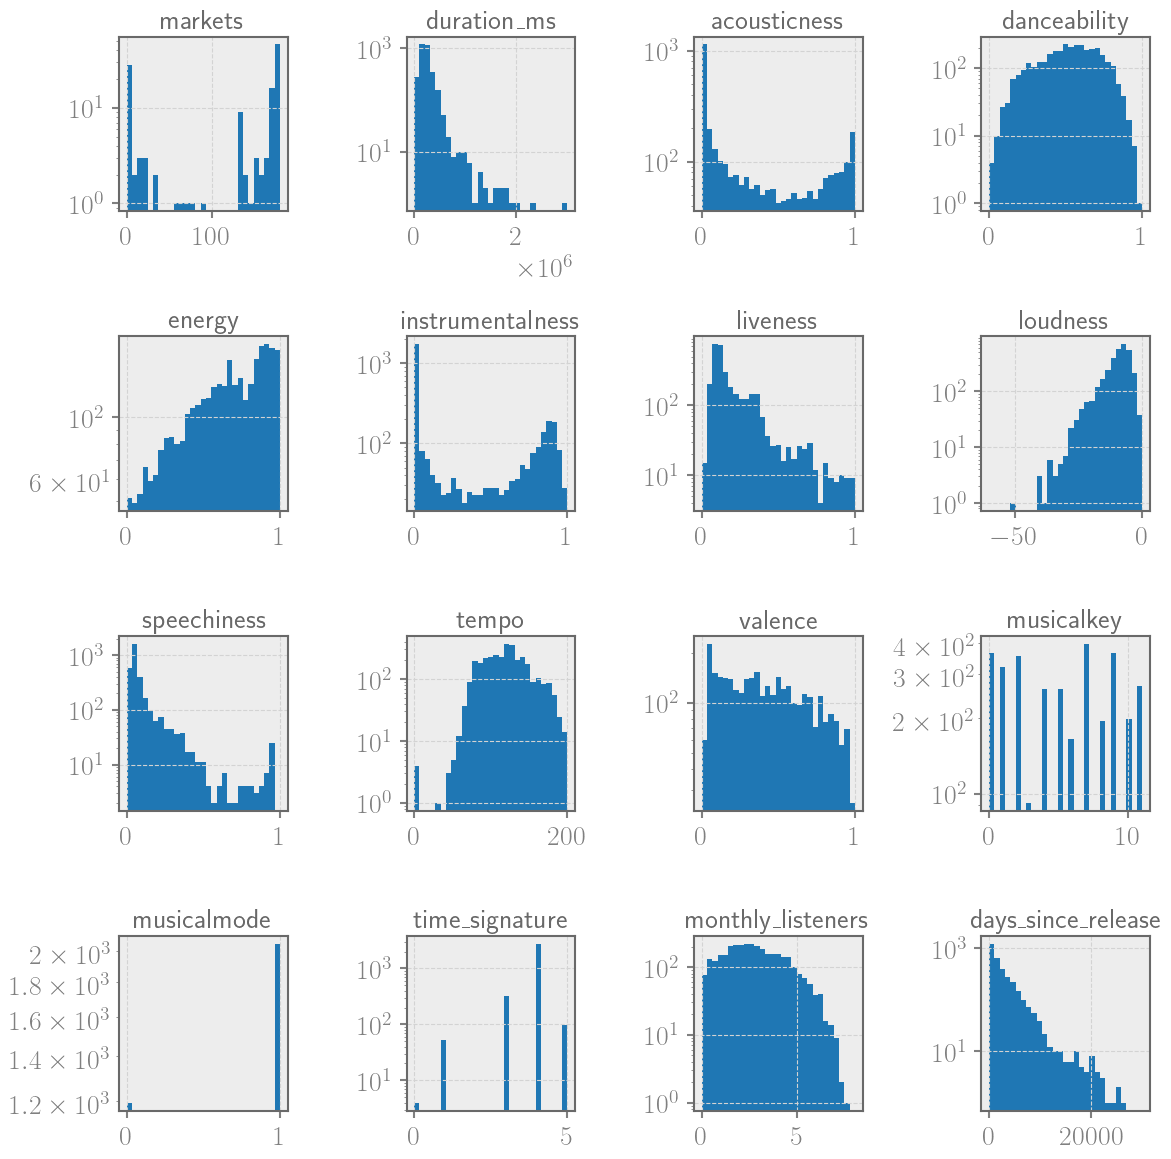

In [17]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Plot on each subplot
for i in range(4):
    for j in range(4):
        featureno = 4*i + j
        vmin, vmax = vmins[features[featureno]], vmaxs[features[featureno]]
        if features[featureno] == 'monthly_listeners':
            axs[i,j].hist(np.log10(df[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30), log=True, lw=2)
        else:
            axs[i,j].hist(df[features[featureno]], bins=np.linspace(vmin, vmax, 30), log=True, lw=2)
        axs[i,j].set_title(features[featureno])

plt.tight_layout()
plt.show()

# load the track data for the dates that exist

In [8]:
DEFAULT_EDIT_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/Editorial-playlists/"
track_info_names = glob.glob(DEFAULT_EDIT_DIR + "track_info_last_24hrs_*.csv")
track_info_dates = [name.split('24hrs_')[1].split('.csv')[0] for name in track_info_names]
artist_info_names = [DEFAULT_EDIT_DIR + 'artists_last_24hrs_'+date+'_info.csv' for date in track_info_dates]

In [9]:
# for track info at each date, load the monthly listeners of the associated artist on that date
# (many artists are featured multiple times in one month)
dfs_edit = []
for track_info_name, artist_info_name in zip(track_info_names, artist_info_names):
    df_edit = pd.read_csv(track_info_name)
    # make sure no duplicate tracks on a particular day, as there was originally an error in this
    # script that added X identical rows for a track with X credit artists
    df_edit.drop_duplicates(subset=['ids'], keep=False, inplace=True)
    df_edit_mnth_lstnrs = pd.read_csv(artist_info_name)
    df_edit_mnth_lstnrs.set_index('ids', inplace=True)

    monthly_listeners, not_found = [], 0
    for ids in df_edit.artists:
        monthly_listeners_ = []
        for id in ids.replace(" ", "").split(','):
            try:
                val = df_edit_mnth_lstnrs.loc[id]['monthly_listeners']
            except KeyError:
                val = -1
            monthly_listeners_.append(val)
        monthly_listeners.append(max(monthly_listeners_))
    df_edit['monthly_listeners'] = monthly_listeners
    dfs_edit.append(df_edit)
    print(f"Number of artists not found: {not_found}")
dfs_edit = pd.concat([df_edit for df_edit in dfs_edit], ignore_index = True)

Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0
Number of artists not found: 0


In [10]:
# convert release date to years since release
days_since_release, num_old_tracks = [], 0
for date in dfs_edit.release_date:
    try:
        days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m-%d')).days)
    except ValueError:
        try:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m')).days)
        except ValueError:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y')).days)
dfs_edit['days_since_release'] = days_since_release

In [11]:
# drop NA and -1 values for the numerical properties
dfs_edit = dfs_edit.dropna(subset=[column for column in dfs_edit.columns if column in features])
dfs_edit = dfs_edit.drop(dfs_edit[(dfs_edit[features] == -1).any(axis=1)].index)
print(dfs_edit.columns)
dfs_edit.describe()

Index(['ids', 'names', 'popularity', 'markets', 'artists', 'release_date',
       'duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'musicalkey', 'musicalmode', 'time_signature',
       'monthly_listeners', 'days_since_release'],
      dtype='object')


,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature,monthly_listeners,days_since_release
count,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6202.000000,6.202000e+03,6202.000000
mean,53.643341,178.013866,193375.420671,0.443449,0.557003,0.489085,0.323379,0.155254,-12.657386,0.073814,117.040154,0.416473,5.154466,0.702838,3.884231,7.734843e+06,1876.992744
std,18.494197,31.383851,54248.216312,0.397100,0.188865,0.318656,0.424658,0.115119,10.019188,0.075522,30.561229,0.251218,3.560793,0.457045,0.457671,1.591445e+07,3760.935614
min,0.000000,0.000000,65374.000000,0.000001,0.060200,0.000020,0.000000,0.022200,-46.866000,0.022700,33.470000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,6.000000
25%,41.000000,184.000000,156646.250000,0.050550,0.428000,0.127250,0.000000,0.097100,-19.430750,0.035500,94.321750,0.203000,2.000000,0.000000,4.000000,1.465600e+05,94.000000
50%,52.000000,185.000000,186004.500000,0.313000,0.568000,0.554000,0.000672,0.111000,-7.918500,0.044700,116.280500,0.382000,5.000000,1.000000,4.000000,6.149750e+05,318.000000
75%,69.000000,185.000000,218733.750000,0.921000,0.705000,0.760000,0.888750,0.161000,-5.400000,0.070775,137.299000,0.612000,8.000000,1.000000,4.000000,6.885011e+06,1242.000000
max,100.000000,185.000000,777346.000000,0.996000,0.973000,0.999000,0.993000,0.948000,0.200000,0.823000,215.926000,0.986000,11.000000,1.000000,5.000000,1.133920e+08,22519.000000


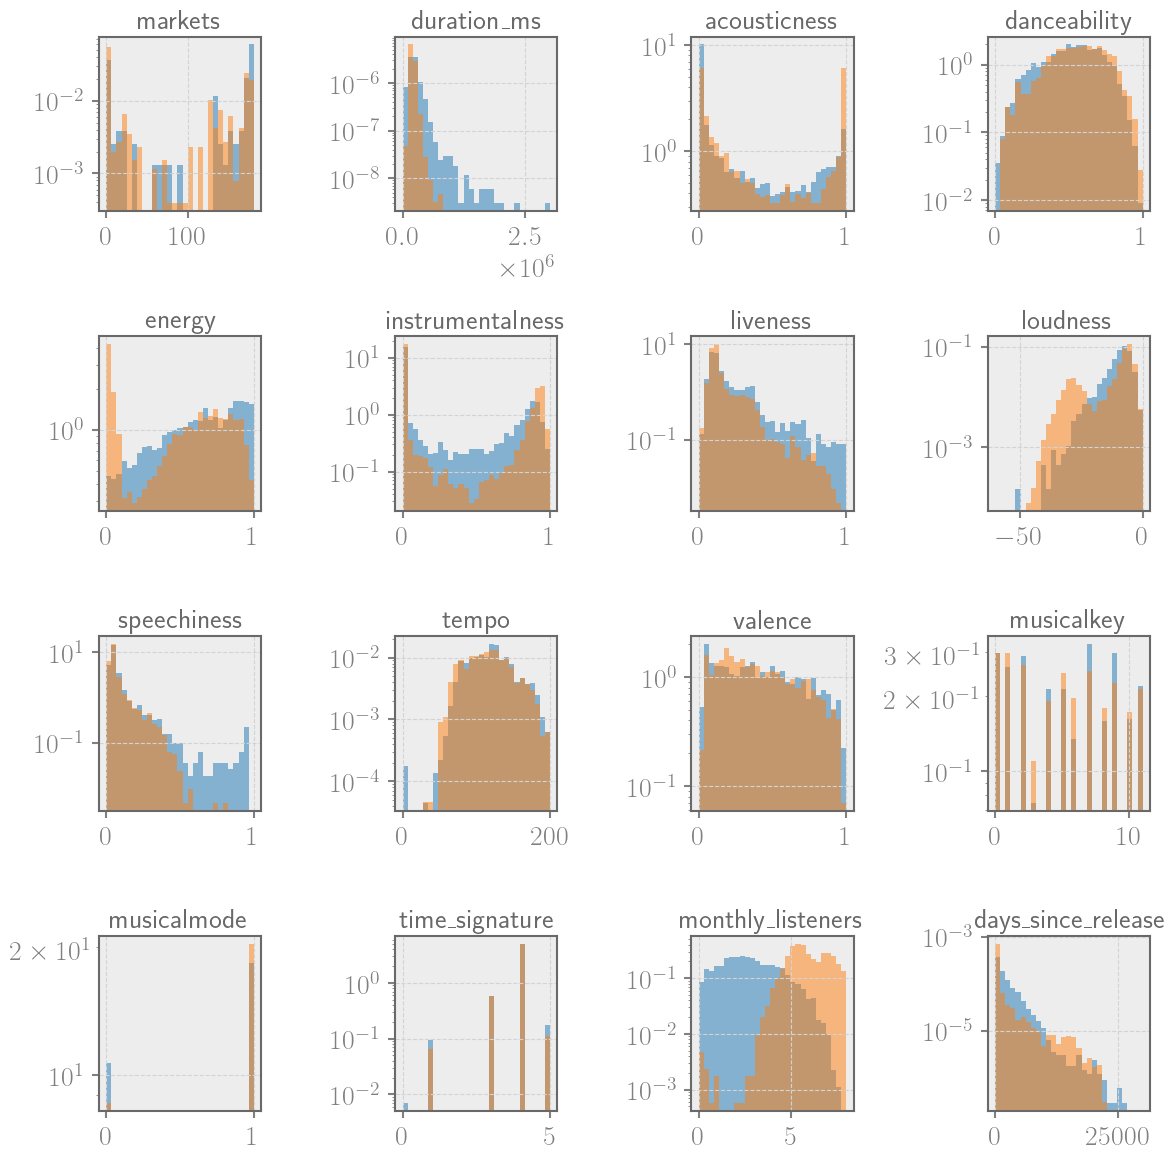

In [20]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Plot on each subplot
for i in range(4):
    for j in range(4):
        featureno = 4*i + j
        vmin, vmax = vmins[features[featureno]], vmaxs[features[featureno]]
        if features[featureno] == 'monthly_listeners':
            axs[i,j].hist(np.log10(df[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30),
                          log=True, lw=2, alpha=0.5, density=True)
            axs[i,j].hist(np.log10(dfs_edit[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30),
                          log=True, lw=2, alpha=0.5, density=True)
        else:
            axs[i,j].hist(df[features[featureno]], bins=np.linspace(vmin, vmax, 30),
                          log=True, lw=2, alpha=0.5, density=True)
            axs[i,j].hist(dfs_edit[features[featureno]], bins=np.linspace(vmin, vmax, 30),
                          log=True, lw=2, alpha=0.5, density=True)
        axs[i,j].set_title(features[featureno])

plt.tight_layout()
plt.show()